In [ ]:
!if [ ! -f plwordnet-4.0.xml ]; then gdown  'https://drive.google.com/uc?export=download&id=1wyjyUwoy3nqcN3ZC-SUKwoXGqPFjypVO'; fi

In [ ]:
def char2vec(word, dictionary):
    word_array = []
    for character in word:
        word_array.append(dictionary[character])
    return word_array

def vec2char(vector, dictionary):
    word_array = []
    for character in vector:
        word_array.append(dictionary[character])
    return word_array


In [ ]:
import re
from IPython.display import clear_output, display
f = open('plwordnet-4.0.xml',"r")
file = f.read()
deminutives = re.findall(r"<lexicalrelations parent=\"([0-9]+)\" child=\"([0-9]+)\" relation=\"56\"\n?.*valid=\"true\" owner=\".*\"\/>", file, re.MULTILINE)

words = re.findall(r"<lexical-unit id=\"([0-9]+)\"\n?( {8})? ?name=\"(.*)\"\n?( {8})? ?pos=\"rzeczownik.*\"\n?( {8})? ?tagcount=\"[0-9]+\"\n?( {8})? ?domain=\".*\"\n?( {8})? ?desc=\".*\"\n?( {8})? ?workstate=\".*\"\n?( {8})? ?source=\".*\"\n?( {8})? ?variant=\"[0-9]+\"/>", file, re.MULTILINE)
numerated_words = {}
id_words = {}
words_dict = {}
characters = set()
relations = set()
max_len = 0
longest = ""
# Dodanie do zbioru numery słów występujące w relacji
for deminutive in deminutives:
    relations.add(int(deminutive[0]))
    relations.add(int(deminutive[1]))

# Dodanie słowa na kluczu
for word in words:
    current = word[2].lower()
    words_dict[int(word[0])] = current


i = 0
# Numerowanie słów występujących w relacjach, liczenie maksymalnej długości słowa, dodawanie liter do zbioru występujących
for key, word in sorted(words_dict.items(), key = lambda kv:(kv[1], kv[0])):
    if key in relations:
        for character in word:
            characters.add(character)
        numerated_words[i] = [word, key]
        id_words[key] = [word, i]
        i+=1
        if max_len < len(word):
            max_len = len(word)

print("longest",max_len)

# Dodanie znaku 0 jako pustej przestrzeni
characters = [chr(0)]+ sorted(characters)

# Utworzenie słownika znak numer
characters_dict = dict([(value, idx) for idx, value in enumerate(characters)])
print (characters_dict)
# Utworzenie słownika numer znak
inv_characters_dict = {v: k for k, v in characters_dict.items()}
# word_to_ix = dict([(value[0], key) for key, value in numerated_words.items()])
word_to_ix = dict([(key, char2vec(value[0].ljust(max_len,chr(0)),characters_dict)) for key, value in numerated_words.items()])
print (word_to_ix)

# Wpisanie wektoryzowanych słów do tablicy
new_relations = [(id_words[int(word2)][1], id_words[int(word1)][1]) for (word1, word2) in deminutives]
x_set = []
y_set = []

# Utworzenie wektora wejściowego i wyjściowego
for x, y in new_relations:
    x_set.append(word_to_ix[x])
    y_set.append(word_to_ix[y])

longest 22
{'\x00': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'w': 22, 'y': 23, 'z': 24, 'ó': 25, 'ą': 26, 'ć': 27, 'ę': 28, 'ł': 29, 'ń': 30, 'ś': 31, 'ź': 32, 'ż': 33}
{0: [2, 3, 2, 33, 21, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1: [2, 3, 2, 33, 21, 18, 6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2: [2, 3, 13, 6, 8, 10, 6, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 3: [2, 3, 13, 6, 8, 10, 6, 18, 6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 4: [2, 5, 10, 5, 2, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 5: [2, 5, 10, 5, 2, 19, 6, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 6: [2, 5, 10, 21, 20, 2, 15, 4, 10, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 7: [2, 5, 10, 21, 20, 2, 15, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 8: [2, 5, 18, 6, 15, 2, 13, 10, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 9: [2, 5, 18, 

In [ ]:
import torch
import numpy as np

dtype = torch.long
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Parmetry wejściowe sieci
N, D_in, H, D_out = len(x_set), max_len, 512, max_len

x_numpy = np.array( x_set )
x = torch.from_numpy(x_numpy).float()
# x = x.to(device)
print(x)

cuda:0
tensor([[17., 16.,  4.,  ...,  0.,  0.,  0.],
        [ 5., 18.,  2.,  ...,  0.,  0.,  0.],
        [12., 16., 31.,  ...,  0.,  0.,  0.],
        ...,
        [ 4.,  6., 13.,  ...,  0.,  0.,  0.],
        [19.,  6., 17.,  ...,  0.,  0.,  0.],
        [17., 10.,  2.,  ...,  0.,  0.,  0.]])


In [ ]:
y_numpy = np.array( y_set )
y = torch.from_numpy(y_numpy).float()
# y = y.to(device)

In [ ]:
from torch import nn
from torch.functional import F

class NeuralNetworkModel(nn.Module):
    def __init__(self):
        # Call the super initializor to register all of the layers implemented here
        super().__init__()

        # Create layers here
        self.layer_input = nn.Linear(D_in,H)
        # self.layer_embedding = nn.Embedding(10, max_len)
        self.layer_hidden_one = nn.Tanh()
        self.layer_hidden_two = nn.Linear(H,H)
        # self.layer_hidden_two = nn.Linear(H,H//2)
        # self.layer_hidden_three = nn.Linear(H//2,H)
        # self.layer_hidden_four= nn.Linear(H,H)
        self.layer_dropout = nn.Dropout(p=0.4)

        self.layer_output = nn.Linear(H,D_out)
    def forward(self, param):
        # Flattened the input to make sure it fits the layer input
        # param = param.view(param.shape[0],-1)
        # Pass in the input to the layer and do forward propagation
        param = F.relu(self.layer_input(param))
        # print("1")
        # param = self.layer_embedding(param)
        param = self.layer_dropout(param)
        param = F.relu(self.layer_hidden_one(param))
        param = F.relu(self.layer_hidden_two(param))
        param = F.relu(self.layer_hidden_two(param))
        param = F.relu(self.layer_hidden_two(param))
        param = F.relu(self.layer_hidden_two(param))
        param = F.relu(self.layer_hidden_two(param))
        # param = F.relu(self.layer_hidden_two(param))
        # param = F.relu(self.layer_hidden_three(param))
        # print("2")
        param = F.relu(self.layer_dropout(param))
        # print("3")


        # print("4")
        # Dimension = 1, to get the sum of the output across the output row matrix
        param = F.relu(self.layer_output(param))
        return param
  

In [ ]:
# Instantiate the model
model = NeuralNetworkModel()
# Get the log probability prediction from our model


log_ps = model(x)
# Normalize the probability by taking the exponent of the log-prob
ps = torch.exp(log_ps)
# Print out the size
print(ps.shape)

torch.Size([4179, 22])


In [ ]:
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate the model
model = NeuralNetworkModel()
# Use Negative Log Likelyhood as our loss function
loss_function = nn.MSELoss(reduction='sum')
# Use ADAM optimizer to utilize momentum and start with a very small learning rate
optimizer = optim.Adam(model.parameters(), lr=0.003)


epochs = 10000
# Initialize two empty arrays to hold the train and test loss every cycle
train_losses, test_losses = [],[]

model.to(device)
x_train = x[0:3000]
y_train = y[0:3000]


x_test = x[3001:]
y_test = y[3001:]
trainloader = [xval for xval in x_train]
# print (trainloader)
for i in range(len(trainloader)):
    trainloader[i] = [trainloader[i], y_train[i]]
testloader = [xval for xval in x_test]
for i in range(len(testloader)):
    testloader[i] = [testloader[i], y_test[i]]


print(len(x_train[0]))
# Start the training
for i in range(epochs):
    running_loss = 0
    # Loop through all of the train set forward and back propagate
    # for x,y in trainloader:
    x_train,y_train = x_train.to(device), y_train.to(device)

    optimizer.zero_grad()                      # Clear the previous gradients
    log_ps = model(x_train)                     # Forwardpropagate 
    loss = loss_function(log_ps, y_train)       # Calculate the loss
    loss.backward()                            # Backpropagate
    optimizer.step()                           # Update the weights
    running_loss += loss.item()                # Accumulate the total loss

    # Initialize test loss and accuracy to be 0 for every start of cycle    
    test_loss = 0
    accuracy = 0
    
    # Turn off the gradients
    with torch.no_grad():
        # Loop through all of the validation set and calculate the validation loss
        # for x, y in testloader:
        x_test,y_test = x_test.to(device), y_test.to(device)
        log_ps = model(x_test)                                 # Forwardpropagate
        ps = torch.exp(log_ps)                                 # Normalize the log-prob
        test_loss += loss_function(log_ps, y_test)             # Accumulate test loss
        top_p, top_class = ps.topk(max_len,1)                    # Get the top probability
        # print(len(top_p), top_class.shape)
        # print(y_test.shape, top_class.shape)
        equals = top_class == y_test.view(*top_class.shape)    # Compare equality with label
        accuracy += torch.mean(equals.type(torch.FloatTensor)) # Get mean of accuracy
    
    # Append the average losses to the array for plotting       
    train_losses.append(running_loss/len(y_train))
    test_losses.append(test_loss/len(x_test))
    
    # Print the result
    if (i+1)%100 == 0:
        clear_output(wait=True)
        print (vec2char(y_test[0].tolist(), inv_characters_dict))
        print (vec2char(top_class[0].tolist(), inv_characters_dict))
        print("Epoch: {}/{}.. ".format(i+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(x_train)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(x_test)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(x_test)))

['k', 'o', 'n', 'i', 'c', 'z', 'e', 'k', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00', '\x00']
['d', ' ', 'a', '\x00', 'c', 'b', 'e', 's', 'n', 'r', 'o', 'p', 'u', 't', 'm', 'f', 'j', 'i', 'g', 'h', 'l', 'k']
Epoch: 10000/10000..  Training Loss: 56.090..  Test Loss: 291.927..  Test Accuracy: 0.000


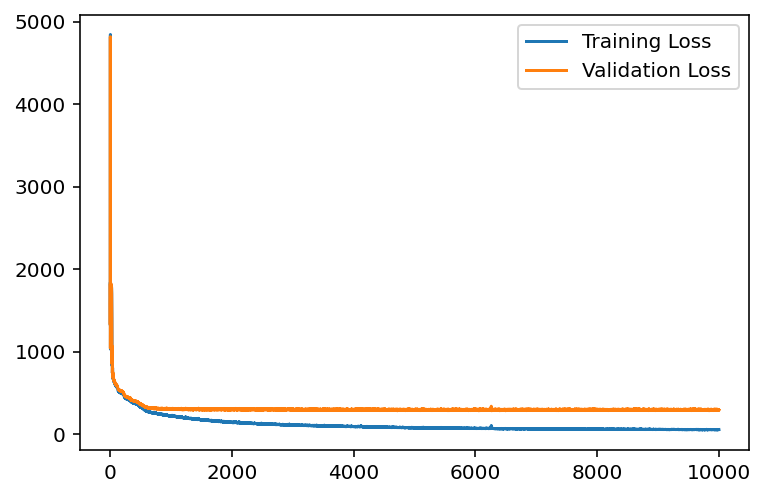

In [ ]:
# Plot the graph here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)